In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import itertools

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt

%matplotlib inline

# 1. Preprocessing

### pandas로 읽어오기

In [3]:
data = pd.read_csv("./sample_data.txt", sep= '\t')
data

,label,meastime,stage,degc,0 Hz,1 Hz,2 Hz,3 Hz,4 Hz,5 Hz,...,9991 Hz,9992 Hz,9993 Hz,9994 Hz,9995 Hz,9996 Hz,9997 Hz,9998 Hz,9999 Hz,10000 Hz
0,0,20200408132629,s1,60.8,3.337466e-15,6.813422e-15,7.246523e-15,8.078009e-15,9.321475e-15,1.169665e-14,...,1.470507e-06,1.227576e-06,8.681997e-07,6.773161e-07,3.666906e-07,1.733466e-07,4.257153e-07,1.146287e-06,2.315876e-06,8.365001e-06
1,0,20200422112911,s7,71.1,3.518254e-14,7.266183e-14,7.994039e-14,9.354825e-14,1.156408e-13,1.538780e-13,...,1.396176e-06,2.875137e-06,1.420636e-06,1.391422e-06,1.892279e-06,3.798289e-06,3.971005e-06,3.528786e-06,1.125920e-05,8.634675e-05
2,0,20200417151032,s2,49.6,3.963802e-15,8.343728e-15,9.659595e-15,1.208021e-14,1.604541e-14,2.275951e-14,...,6.257802e-08,9.304342e-08,6.333435e-08,2.357872e-07,4.400379e-07,2.393002e-06,3.405056e-06,9.397469e-07,2.325818e-06,1.280774e-06
3,0,20200422150542,s6,53.5,7.786948e-15,1.609174e-14,1.774796e-14,2.082929e-14,2.614301e-14,3.435657e-14,...,4.884777e-07,4.677642e-07,2.229568e-06,3.888228e-06,1.698461e-05,1.836729e-05,4.214171e-06,1.012343e-05,3.617143e-06,6.269778e-07
4,0,20200408085215,s4,63.9,2.142766e-14,4.349323e-14,4.547246e-14,4.902936e-14,5.487627e-14,6.301525e-14,...,5.531142e-07,2.072130e-06,4.804855e-06,3.355894e-05,6.870571e-05,5.572402e-05,4.573358e-05,8.669402e-06,7.253392e-06,2.876429e-06
5,0,20200401191456,s4,65.7,2.843588e-14,5.801749e-14,6.162536e-14,6.824914e-14,7.935923e-14,9.583618e-14,...,5.749289e-07,1.237595e-06,2.035427e-06,3.650389e-06,2.307347e-06,1.587144e-06,1.847724e-06,2.877964e-06,1.431568e-06,8.458068e-07
6,0,20200408102603,s8,64.6,8.259474e-14,1.702583e-13,1.863012e-13,2.160825e-13,2.634671e-13,3.383763e-13,...,6.412776e-06,4.315448e-06,1.264098e-05,3.491533e-06,5.281232e-07,6.817123e-07,5.579179e-07,8.248013e-07,3.683016e-07,6.676920e-07
7,0,20200416164405,s7,64.7,2.524975e-15,5.348803e-15,6.297586e-15,8.035920e-15,1.081191e-14,1.561049e-14,...,1.000111e-07,1.580460e-07,6.672723e-08,1.164466e-07,1.556111e-07,1.806838e-07,3.742918e-07,9.549482e-07,6.392315e-06,1.158501e-05
8,1,20200408113925,s5,66.6,2.519073e-14,5.163043e-14,5.555720e-14,6.280223e-14,7.374439e-14,9.363082e-14,...,4.829257e-07,5.904012e-07,6.122929e-07,3.724896e-07,5.890676e-07,1.067424e-06,5.973574e-06,1.412959e-05,2.751901e-05,1.315984e-05
9,1,20200417192412,s5,62.2,1.464507e-14,3.071371e-14,3.522177e-14,4.360136e-14,5.732303e-14,8.108217e-14,...,7.710664e-07,6.492042e-07,8.085241e-07,5.665101e-07,1.844271e-06,5.445187e-06,4.123601e-05,6.119383e-05,2.029021e-05,3.086149e-05


### spectrum 값만 가져오기

In [4]:
spectrum = data.loc[:,'0 Hz':]

### label 데이터 별도 저장 (추후 spectrum 데이터 추출 부분과 통합)

In [5]:
labels = data.loc[:,:'label']
labels

,label
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,1
9,1


### Augmentation - SMOTE

In [6]:
# serialize before SMOTE
specs = np.array(spectrum)
labels = np.array(labels)

In [17]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0, k_neighbors=1) #k_neighbors 옵션 제거
specs, labels = sm.fit_sample(specs, labels)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
len(labels_over)

16

In [19]:
labels_over

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

# 2. Spectrogram

In [6]:
# numpy array 로 변환
specs = np.array(spectrum)


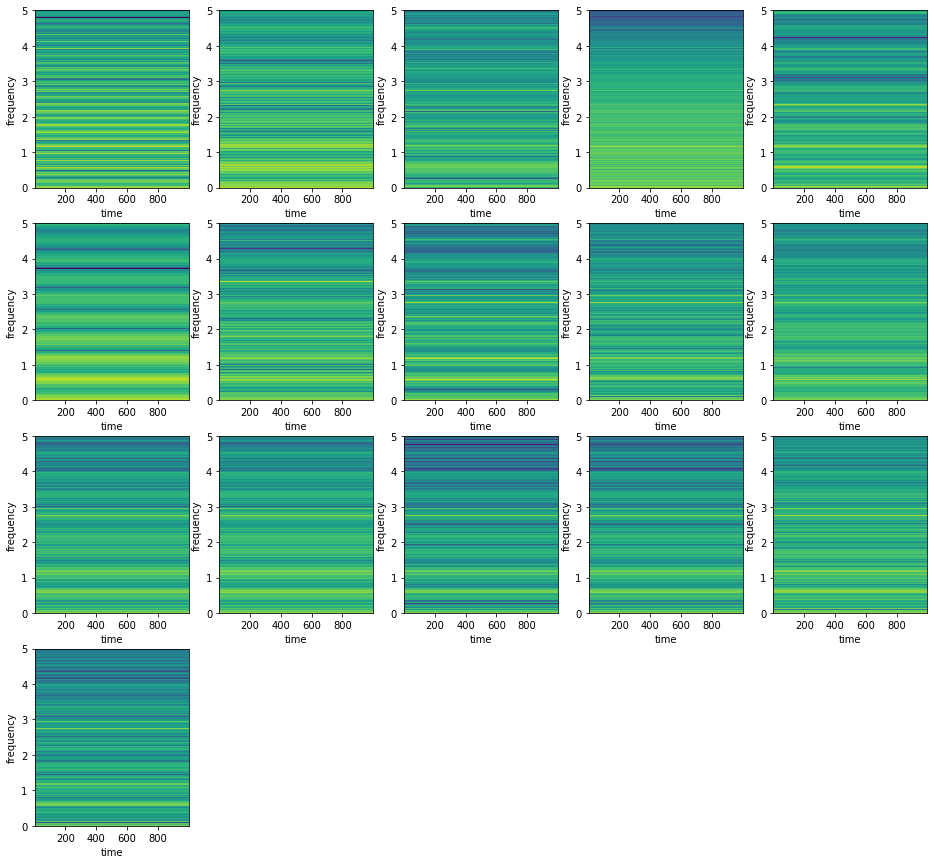

In [41]:
# SMOTE 결과 데이터에 대해 spectrogram 생성 테스트
plt.rcParams["figure.figsize"] = (16,15)
for i in range(len(specs)):
    plt.subplot(4,5,i+1)
#     plt.specgram(list(specs[i]), NFFT=10000, Fs=10, noverlap=5, detrend='mean', mode='psd')
    plt.specgram(list(specs[i]), NFFT=10000, Fs=10, noverlap=5)
    # plt.specgram(list(spec), Fs=100)
    plt.xlabel('time')
    plt.ylabel('frequency')

plt.show()

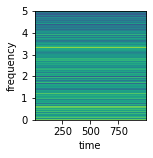

In [38]:
# test로 spectrogram 생성
plt.rcParams["figure.figsize"] = (2,2)
plt.specgram(list(specs[15]), NFFT=10000, Fs=10, noverlap=5, detrend='mean', mode='psd')
plt.xlabel('time')
plt.ylabel('frequency')
plt.show()

In [47]:
# Input : numpy array
# Output : spectrogram numpy array

def spec_array(arr):
    plt.axis('off') # "invisable" axis in plot
    plt.xticks([]), plt.yticks([])
    plt.use_sticky_edges = True
    plt.margins(0)
    plt.rcParams["figure.figsize"] = (2,2)
    plt.specgram(list(arr), NFFT=10000, Fs=10, noverlap=5, detrend='mean', mode='psd')
    fig = plt.figure(1, tight_layout=True)
    fig.canvas.draw()
    fig.tight_layout(pad=0)
#     plt.close()
    
    # Now we can save it to a numpy array.
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     return np.array(fig.canvas.renderer._renderer)
    return data
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


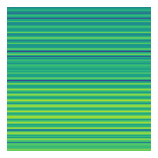

In [48]:
spec_arr = spec_array(specs[0])
# spec_arr

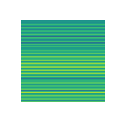

In [49]:
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.use_sticky_edges = True
plt.imshow(spec_arr)
plt.show()

# 3. Data Load

### split data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


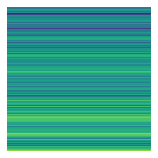

In [50]:
data = []
for spec in specs:
    arr = spec_array(spec)
    data.append(arr)

In [51]:
data

[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [52]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [53]:
# validation 참조 https://discuss.pytorch.org/t/how-to-split-dataset-into-test-and-validation-sets/33987/5
datasets = train_test_split(data)
datasets

[[array([[[ 30, 151, 138],
          [ 30, 151, 138],
          [ 30, 151, 138],
          ...,
          [ 30, 151, 138],
          [ 30, 151, 138],
          [ 30, 151, 138]],
  
         [[ 32, 145, 140],
          [ 32, 145, 140],
          [ 32, 145, 140],
          ...,
          [ 32, 145, 140],
          [ 32, 145, 140],
          [ 32, 145, 140]],
  
         [[ 31, 161, 135],
          [ 31, 161, 135],
          [ 31, 161, 135],
          ...,
          [ 31, 161, 135],
          [ 31, 161, 135],
          [ 31, 161, 135]],
  
         ...,
  
         [[ 71, 192, 110],
          [ 71, 192, 110],
          [ 71, 192, 110],
          ...,
          [ 71, 192, 110],
          [ 71, 192, 110],
          [ 71, 192, 110]],
  
         [[ 62, 188, 115],
          [ 62, 188, 115],
          [ 62, 188, 115],
          ...,
          [ 62, 188, 115],
          [ 62, 188, 115],
          [ 62, 188, 115]],
  
         [[129, 211,  76],
          [129, 211,  76],
          [129, 211,  76

In [54]:
print(len(datasets[0]))
print(len(datasets[1]))

12
4


In [55]:
trainloader = torch.utils.data.DataLoader(datasets[0], batch_size=1,shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(datasets[1], batch_size=1,shuffle=False, num_workers=2)